In [1]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy as sp
from scipy import stats, signal
import random
from sklearn import svm # needed for svm
from sklearn.metrics import confusion_matrix
import itertools

# Each accelerometer log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampMs, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        
        # sensorTimestampMs comes from the Arduino function 
        # https://www.arduino.cc/reference/en/language/functions/time/millis/
        # which returns the number of milliseconds passed since the Arduino board began running the current program.
        self.sensorTimestampMs = sensorTimestampMs.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # Calculate the magnitude of the signal
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
        self.sampleLengthInSecs = (self.currentTimeMs[-1] - self.currentTimeMs[0]) / 1000.0
        self.samplesPerSecond = len(self.currentTimeMs) / self.sampleLengthInSecs 
        
    # Returns a dict of numpy arrays for each axis of the accel + magnitude
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Returns a dict of numpy arrays for each axis of the accel + magnitude
    def get_processed_data(self):
        return {"x_p":self.x_p, "y_p":self.y_p, "z_p":self.z_p, "mag_p":self.mag_p}
    
    # Creates a new padded version of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    # See: https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.pad.html
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x_padded = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y_padded = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z_padded = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag_padded = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object
# In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
# that may be recorded simultaneously
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.accelLogFilename = os.path.basename(accelLogFilenameWithPath)
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData)
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.gestureName, self.trialNum, self.accelLogFilename)

# Container for a single set of gestures and trials
class GestureSet:
    
    def __init__(self, gesture_log_path, map_gestures_to_trials):
        self.path = gesture_log_path
        self.map_gestures_to_trials = map_gestures_to_trials 

    # returns the longest trial (based on num rows recorded and not clock time)
    def get_longest_trial(self):
        longest_trial_length = -1
        longest_trial = None
        for gesture_name, trial_list in self.map_gestures_to_trials.items():
            for trial in trial_list:
                if longest_trial_length < len(trial.accel.x):
                    longest_trial_length = len(trial.accel.x)
                    longest_trial = trial
        return longest_trial
    
    # returns the base path
    def get_base_path(self):
        return os.path.basename(os.path.normpath(self.path))
    
    # returns the number of gestures
    def get_num_gestures(self):
        return len(self.map_gestures_to_trials)
    
    # returns trials for a gesture name
    def get_trials_for_gesture(self, gesture_name):
        return self.map_gestures_to_trials[gesture_name]
    
    # creates an aggregate signal based on *all* trials for this gesture
    # TODO: in future could add in an argument, which takes a list of trial nums
    # to use to produce aggregate signal
    def create_aggregate_signal(self, gesture_name, signal_var_name):
        trials = self.get_trials_for_gesture(gesture_name)
        aggregate_signal = None
        trial_signals = []
        trial_signals_original = []
        first_trial = None
        first_trial_signal = None
        
        max_length = -1
        for trial in trials:
            trial_signal = getattr(trial.accel, signal_var_name)
            if max_length < len(trial_signal):
                max_length = len(trial_signal)
            
        for i in range(len(trials)):
            if i == 0:
                first_trial = trials[i]
                trial_signal = getattr(first_trial.accel, signal_var_name)
                trial_signal_mod = np.copy(trial_signal)

                trial_signals.append(trial_signal_mod)
                trial_signals_original.append(trial_signal)
                
                array_length_diff = max_length - len(trial_signal_mod)
                trial_signal_mod = np.pad(trial_signal_mod, (0, array_length_diff), 'mean')  

                aggregate_signal = trial_signal_mod
                first_trial_signal = trial_signal_mod
            else:

                cur_trial = trials[i]
                cur_trial_signal = getattr(trial.accel, signal_var_name) 
                trial_signals_original.append(cur_trial_signal)
                
                array_length_diff = max_length - len(cur_trial_signal)
                cur_trial_signal_mod = np.pad(cur_trial_signal, (0, array_length_diff), 'mean') 

                cur_trial_signal_mod = get_aligned_signal_cutoff_and_pad(cur_trial_signal_mod, first_trial_signal)
                trial_signals.append(cur_trial_signal_mod)
                aggregate_signal += cur_trial_signal_mod
        
        mean_signal = aggregate_signal / len(trial_signals) 
        return mean_signal

    # Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
    # different number. We should have the same number of trials across all gestures)
    def get_min_num_of_trials(self):
        minNumTrials = -1 
        for gestureName, trialSet in self.map_gestures_to_trials.items():
            if minNumTrials == -1 or minNumTrials > len(trialSet):
                minNumTrials = len(trialSet)
        return minNumTrials

    # returns the total number of trials
    def get_total_num_of_trials(self):
        numTrials = 0 
        for gestureName, trialSet in self.map_gestures_to_trials.items():
            numTrials = numTrials + len(trialSet)
        return numTrials
    
    # get random gesture name
    def get_random_gesture_name(self):
        gesture_names = list(self.map_gestures_to_trials.keys())
        rand_gesture_name = gesture_names[random.randint(0, len(gesture_names) - 1)]
        return rand_gesture_name
    
    # get random trial
    def get_random_trial(self):
        rand_gesture_name = self.get_random_gesture_name()
        print("rand_gesture_name", rand_gesture_name)
        trials_for_gesture = self.map_gestures_to_trials[rand_gesture_name]
        return trials_for_gesture[random.randint(0, len(trials_for_gesture) - 1)]
    
    # returns a sorted list of gesture names
    def get_gesture_names_sorted(self):
        return sorted(self.map_gestures_to_trials.keys())
    
    # prettify the str()
    def __str__(self):
         return "'{}' : {} gestures and {} total trials".format(self.path, self.get_num_gestures(), self.get_total_num_of_trials())
        

In [2]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]


# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials_individual( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        timeMs = filenameParts[1]
        numRows = int(filenameParts[2])
        sensorName = "Accelerometer" # currently only one sensor but could expand to more
        
        print("gestureName={} timeMs={} numRows={}".format(gestureName, timeMs, numRows))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # CSE599TODO: You'll want to loop through the sensor signals and preprocess them
    # Some things to explore: padding signal to equalize length between trials, smoothing, detrending, and scaling
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            # preprocess each signal
            x = 0; # no-op just delete this
          
    return mapGestureNameToTrialList


# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        
        # parse filename into meaningful parts
        # print(csvFilename)
        filenameNoExt = os.path.splitext(csvFilename)[0];
        
        filenameParts = filenameNoExt.split("_")
        gestureName = None
        timeMs = None
        numRows = None
        sensorName = "Accelerometer" # currently only one sensor but could expand to more
            
        # Added this conditional on May 15, 2019 because Windows machines created differently formatted
        # filenames from Macs. Windows machines automatically replaced the character "'"
        # with "_", which affects filenames like "Midair Zorro 'Z'_1556730840228_206.csv"
        # which come out like "Midair Zorro _Z__1557937136974_211.csv" instead
        if '__' in filenameNoExt:
            filename_parts1 = filenameNoExt.split("__")
            gestureName = filename_parts1[0]
            gestureName = gestureName.replace('_',"'")
            gestureName += "'"
            
            filename_parts2 = filename_parts1[1].split("_")
            timeMs = filename_parts2[0]
            numRows = filename_parts2[1]
        else:
            filenameParts = filenameNoExt.split("_")
            gestureName = filenameParts[0]
            timeMs = filenameParts[1]
            numRows = int(filenameParts[2])
        
        # print("gestureName={} timeMs={} numRows={}".format(gestureName, timeMs, numRows))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc. in order)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Perform some preprocessing
    listSamplesPerSec = list()
    listTotalSampleTime = list()
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Padding all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 

            listSamplesPerSec.append(trial.accel.samplesPerSecond)
            listTotalSampleTime.append(trial.accel.sampleLengthInSecs)
            
            # preprocess signal before classification and store in new arrays
            trial.accel.x_p = preprocess(trial.accel.x, maxArrayLength)
            trial.accel.y_p = preprocess(trial.accel.y, maxArrayLength)
            trial.accel.z_p = preprocess(trial.accel.z, maxArrayLength)
            trial.accel.mag_p = preprocess(trial.accel.mag, maxArrayLength)
            
            
    print("Avg samples/sec across {} sensor files: {:0.1f}".format(len(listSamplesPerSec), sum(listSamplesPerSec)/len(listSamplesPerSec)))
    print("Avg sample length across {} sensor files: {:0.1f}s".format(len(listTotalSampleTime), sum(listTotalSampleTime)/len(listTotalSampleTime)))
    print()
    return mapGestureNameToTrialList

# Performs some basic preprocesing on rawSignal and returns the preprocessed signal in a new array
def preprocess(rawSignal, maxArrayLength):
    meanFilterWindowSize = 10
    arrayLengthDiff = maxArrayLength - len(rawSignal)

    # CSE599 TODO: add in your own preprocessing here
    # Just smoothing the signal for now with a mean filter
    smoothed = np.convolve(rawSignal, np.ones((meanFilterWindowSize,))/meanFilterWindowSize, mode='valid')
    return smoothed

# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

# Helper function to align signals. 
# Returns a shifted signal of a based on cross correlation and a roll function
def get_aligned_signal(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    a_shifted = np.roll(a, index_shift - 1) 
    return a_shifted

# Returns a shifted signal of a based on cross correlation and padding
def get_aligned_signal_cutoff_and_pad(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    index_shift_abs = abs(index_shift - 1)
    a_shifted_cutoff = None
    if (index_shift - 1) < 0:
        a_shifted_cutoff = a[index_shift_abs:]
        a_shifted_cutoff = np.pad(a_shifted_cutoff, (0, index_shift_abs), 'mean')
    else:
        a_shifted_cutoff = np.pad(a, (index_shift_abs,), 'mean')
        a_shifted_cutoff = a_shifted_cutoff[:len(a)]
    return a_shifted_cutoff

# calculate zero crossings
# See: https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
# TODO: in future, could have a min_width detection threshold that ignores 
# any changes < min_width samples after an initial zero crossing was detected
# TODO: could also have a mininum height after the zero crossing (withing some window)
# to eliminate noise
def calc_zero_crossings(s):
    # I could not get the speedier solutions to work reliably so here's a 
    # custom non-Pythony solution
    cur_pt = s[0]
    zero_crossings = []
    for ind in range(1, len(s)):
        next_pt = s[ind]
        
        if ((next_pt < 0 and cur_pt > 0) or (next_pt > 0 and cur_pt < 0)):
            zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt > 0:
            # check for previous points less than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt < 0:
                zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt < 0:
            # check for previous points greater than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt > 0:
                zero_crossings.append(ind)
            
        cur_pt = s[ind]
    return zero_crossings

In [4]:
# Load the data
root_gesture_log_path = '/Users/rashmi/project_local/ProjectDanceGesture/Our stuff/realtimegesturesegmentation/GestureLogs/' # this dir should have a set of gesture sub-directories
print(get_immediate_subdirectories(root_gesture_log_path))
gesture_log_paths = get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None
selected_gesture_set_Jon_easy = None
selected_gesture_set_Jon_hard = None
for gesture_log_path in gesture_log_paths:
    
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Reading in:", path_to_gesture_log)
    map_gestures_to_trials = parse_and_create_gesture_trials(path_to_gesture_log)
    gesture_set = GestureSet(gesture_log_path, map_gestures_to_trials)
    map_gesture_sets[gesture_set.get_base_path()] = gesture_set
    if "Rashmi" in gesture_log_path:
        selected_gesture_set = gesture_set
        
if selected_gesture_set is not None:
    print("The selected gesture set:", selected_gesture_set)

def get_gesture_set_with_str(str):
    for base_path, gesture_set in map_gesture_sets.items():
        if str in base_path:
            return gesture_set
    return None

['NicoleGesturesFinal', 'CombinedGestures', 'RashmiGesturesFinal']
Reading in: /Users/rashmi/project_local/ProjectDanceGesture/Our stuff/realtimegesturesegmentation/GestureLogs/NicoleGesturesFinal
Found 25 csv files in /Users/rashmi/project_local/ProjectDanceGesture/Our stuff/realtimegesturesegmentation/GestureLogs/NicoleGesturesFinal
Found 5 gestures
Found 5 trials for 'Clap'
Found 5 trials for 'Dont pay Attention'
Found 5 trials for 'Pulling'
Found 5 trials for 'Flip'
Found 5 trials for 'Elephant Arm'
Max trial length across all gesture is 'Elephant Arm' Trial 0 with 2727 sensor events. Padding all arrays to match
Avg samples/sec across 25 sensor files: 78.8
Avg sample length across 25 sensor files: 13.1s

Reading in: /Users/rashmi/project_local/ProjectDanceGesture/Our stuff/realtimegesturesegmentation/GestureLogs/CombinedGestures
Found 50 csv files in /Users/rashmi/project_local/ProjectDanceGesture/Our stuff/realtimegesturesegmentation/GestureLogs/CombinedGestures
Found 5 gestures
F

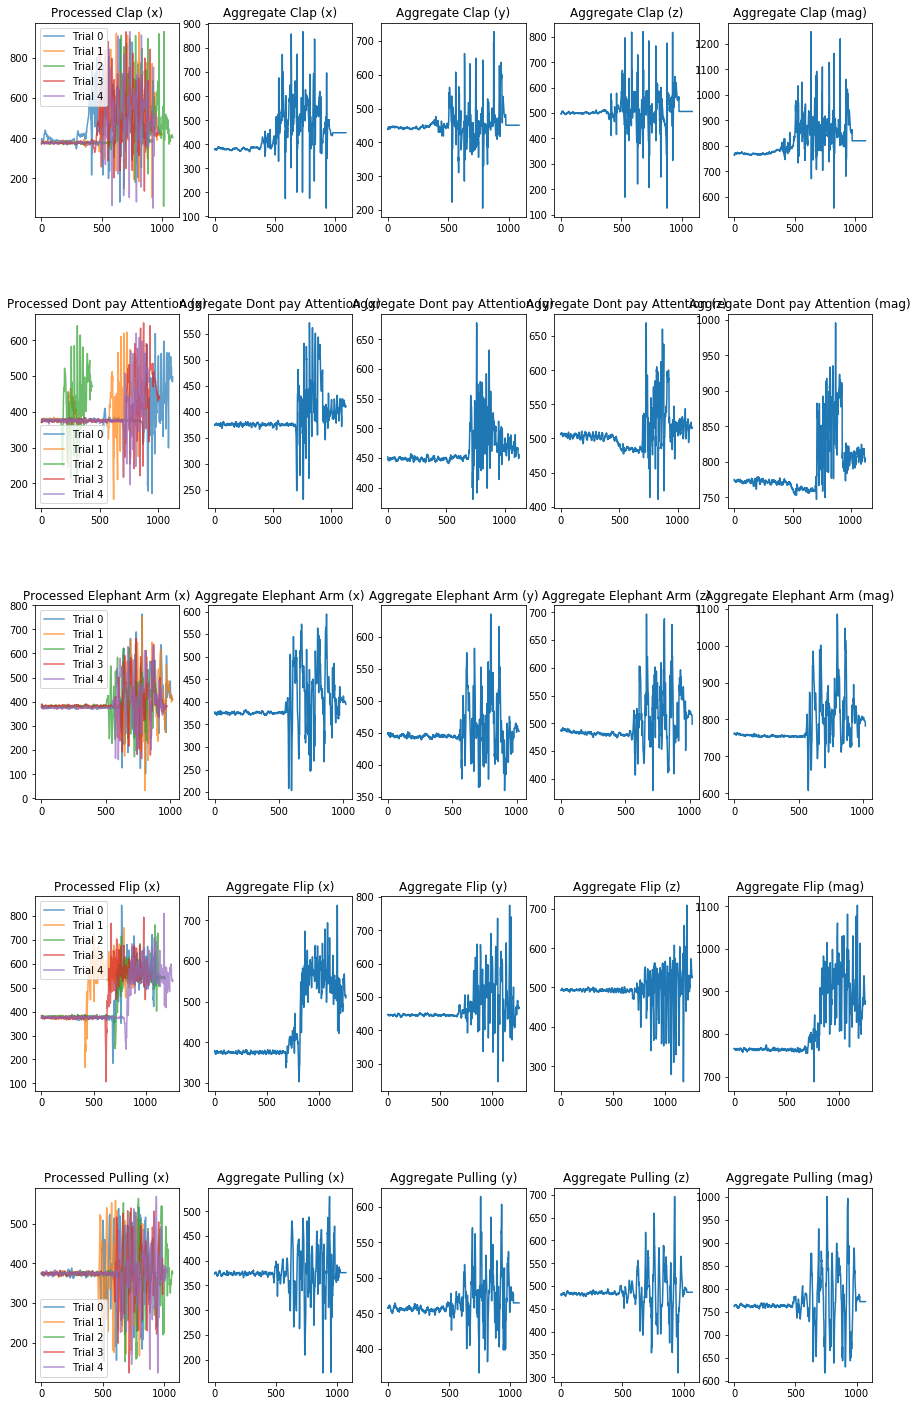

In [10]:
#Plotting mean raw values (Rashmi)
# Let's plot the processed x signal, an aggregate signal, and the spectral analysis 
# of that signal. Because our sampling rate is ~77Hz (see trial.samplesPerSecond), the
# highest frequency we can detect is 77/2 (38.5Hz) due to the NyQuist frequency but this
# should be fine for human gesture motion
#
# I'm plotting the aggregate signal to see if there are *overall* trends in the data
# that we can take advantage of

selected_gesture_set = get_gesture_set_with_str("Rashmi")
map_gestures_to_trials = selected_gesture_set.map_gestures_to_trials
fig, axes = plt.subplots(len(map_gestures_to_trials), 5, figsize=(15, 5 * len(map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(map_gestures_to_trials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = map_gestures_to_trials[gestureName]
    trialNum = 0
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title("Unprocessed " + gestureName + " (x)")
    axes[index][0].legend()
    
    aggregate_x = selected_gesture_set.create_aggregate_signal(gestureName, "x")
    axes[index][1].plot(aggregate_x, label="Aggregate")
    axes[index][1].set_title("Aggregate " + gestureName + " (x)")
    
    aggregate_y = selected_gesture_set.create_aggregate_signal(gestureName, "y")
    axes[index][2].plot(aggregate_y, label="Aggregate")
    axes[index][2].set_title("Aggregate " + gestureName + " (y)")
    
    aggregate_z = selected_gesture_set.create_aggregate_signal(gestureName, "z")
    axes[index][3].plot(aggregate_z, label="Aggregate")
    axes[index][3].set_title("Aggregate " + gestureName + " (z)")
    
    aggregate_mag = selected_gesture_set.create_aggregate_signal(gestureName, "mag")
    axes[index][4].plot(aggregate_mag, label="Aggregate")
    axes[index][4].set_title("Aggregate " + gestureName + " (mag)")

    index = index + 1

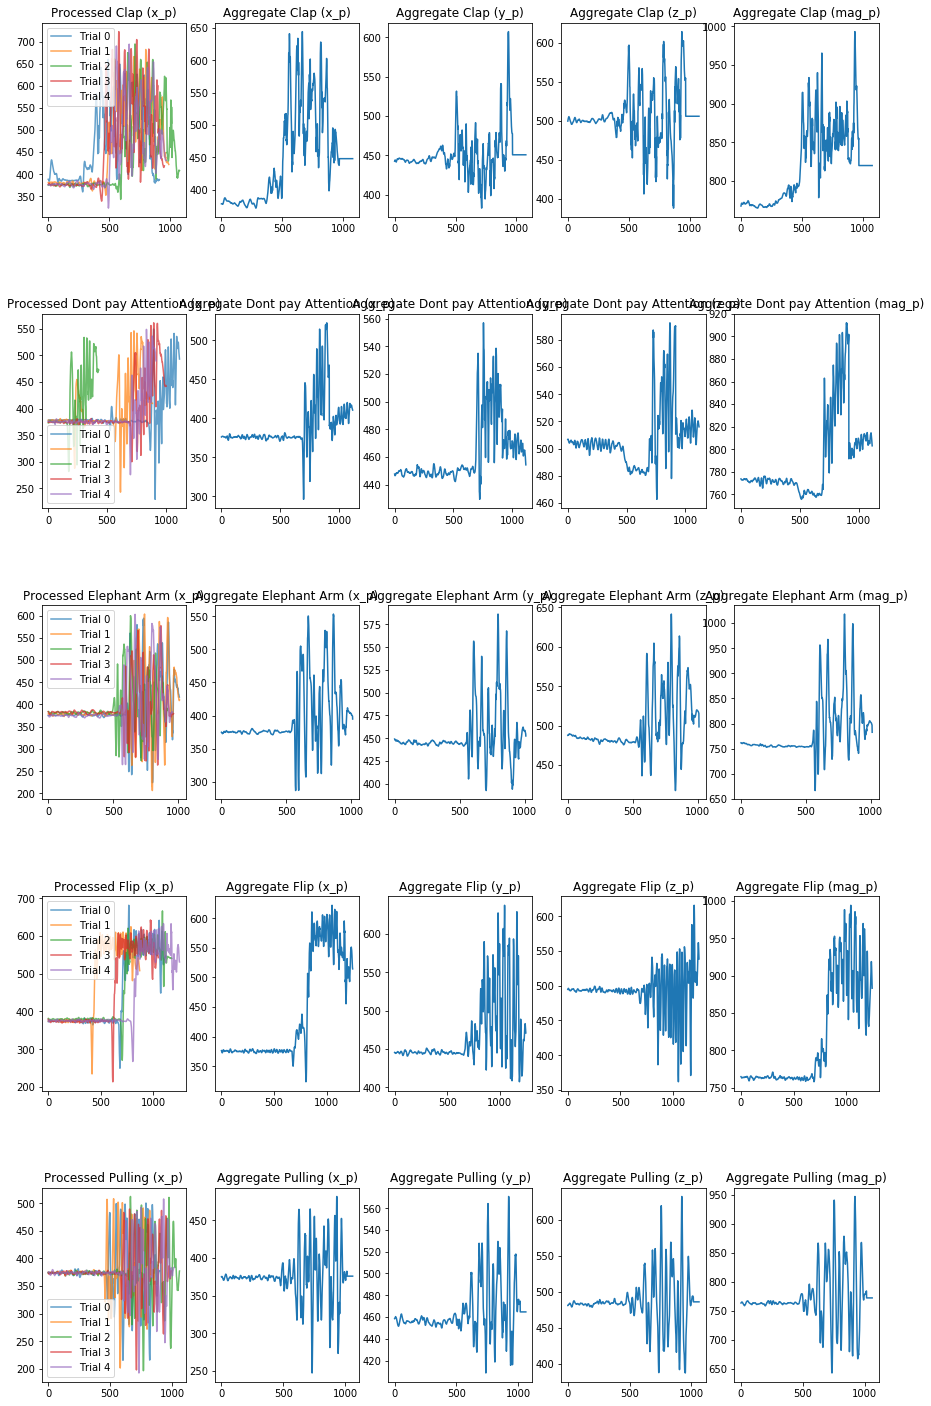

In [11]:
#Plotting mean processed values (Rashmi)
# Let's plot the processed x signal, an aggregate signal, and the spectral analysis 
# of that signal. Because our sampling rate is ~77Hz (see trial.samplesPerSecond), the
# highest frequency we can detect is 77/2 (38.5Hz) due to the NyQuist frequency but this
# should be fine for human gesture motion
#
# I'm plotting the aggregate signal to see if there are *overall* trends in the data
# that we can take advantage of

selected_gesture_set = get_gesture_set_with_str("Rashmi")
map_gestures_to_trials = selected_gesture_set.map_gestures_to_trials
fig, axes = plt.subplots(len(map_gestures_to_trials), 5, figsize=(15, 5 * len(map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(map_gestures_to_trials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = map_gestures_to_trials[gestureName]
    trialNum = 0
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x_p, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title("Processed " + gestureName + " (x_p)")
    axes[index][0].legend()
    
    aggregate_x_p = selected_gesture_set.create_aggregate_signal(gestureName, "x_p")
    axes[index][1].plot(aggregate_x_p, label="Aggregate")
    axes[index][1].set_title("Aggregate " + gestureName + " (x_p)")
    
    aggregate_y_p = selected_gesture_set.create_aggregate_signal(gestureName, "y_p")
    axes[index][2].plot(aggregate_y_p, label="Aggregate")
    axes[index][2].set_title("Aggregate " + gestureName + " (y_p)")
    
    aggregate_z_p = selected_gesture_set.create_aggregate_signal(gestureName, "z_p")
    axes[index][3].plot(aggregate_z_p, label="Aggregate")
    axes[index][3].set_title("Aggregate " + gestureName + " (z_p)")
    
    aggregate_mag_p = selected_gesture_set.create_aggregate_signal(gestureName, "mag_p")
    axes[index][4].plot(aggregate_mag_p, label="Aggregate")
    axes[index][4].set_title("Aggregate " + gestureName + " (mag_p)")

    index = index + 1

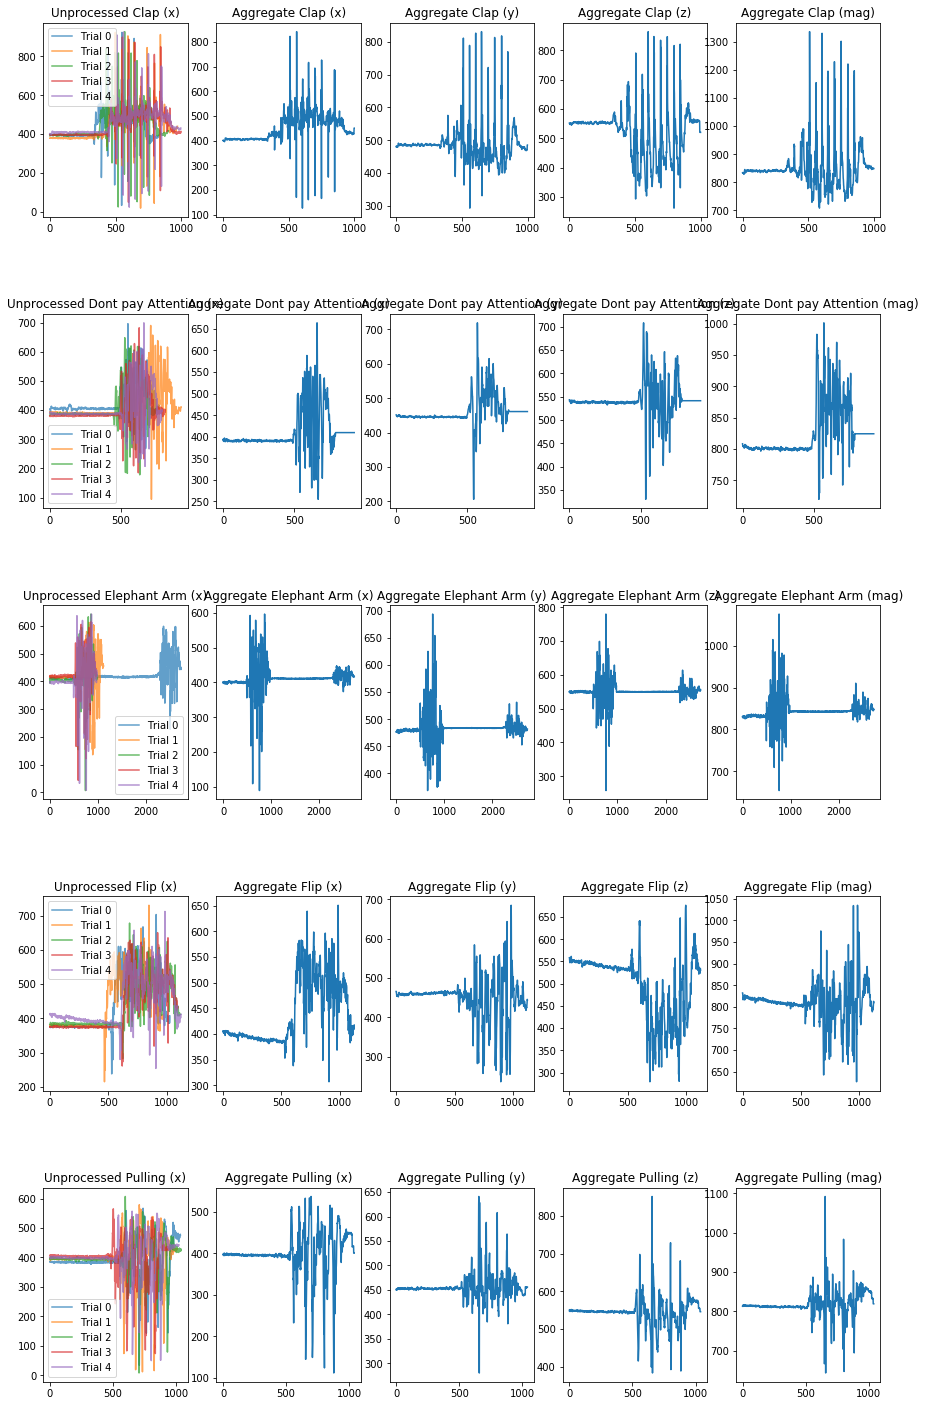

In [12]:
#Plotting mean raw values (Nicole)
# Let's plot the processed x signal, an aggregate signal, and the spectral analysis 
# of that signal. Because our sampling rate is ~77Hz (see trial.samplesPerSecond), the
# highest frequency we can detect is 77/2 (38.5Hz) due to the NyQuist frequency but this
# should be fine for human gesture motion
#
# I'm plotting the aggregate signal to see if there are *overall* trends in the data
# that we can take advantage of

selected_gesture_set = get_gesture_set_with_str("Nicole")
map_gestures_to_trials = selected_gesture_set.map_gestures_to_trials
fig, axes = plt.subplots(len(map_gestures_to_trials), 5, figsize=(15, 5 * len(map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(map_gestures_to_trials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = map_gestures_to_trials[gestureName]
    trialNum = 0
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title("Unprocessed " + gestureName + " (x)")
    axes[index][0].legend()
    
    aggregate_x = selected_gesture_set.create_aggregate_signal(gestureName, "x")
    axes[index][1].plot(aggregate_x, label="Aggregate")
    axes[index][1].set_title("Aggregate " + gestureName + " (x)")
    
    aggregate_y = selected_gesture_set.create_aggregate_signal(gestureName, "y")
    axes[index][2].plot(aggregate_y, label="Aggregate")
    axes[index][2].set_title("Aggregate " + gestureName + " (y)")
    
    aggregate_z = selected_gesture_set.create_aggregate_signal(gestureName, "z")
    axes[index][3].plot(aggregate_z, label="Aggregate")
    axes[index][3].set_title("Aggregate " + gestureName + " (z)")
    
    aggregate_mag = selected_gesture_set.create_aggregate_signal(gestureName, "mag")
    axes[index][4].plot(aggregate_mag, label="Aggregate")
    axes[index][4].set_title("Aggregate " + gestureName + " (mag)")

    index = index + 1

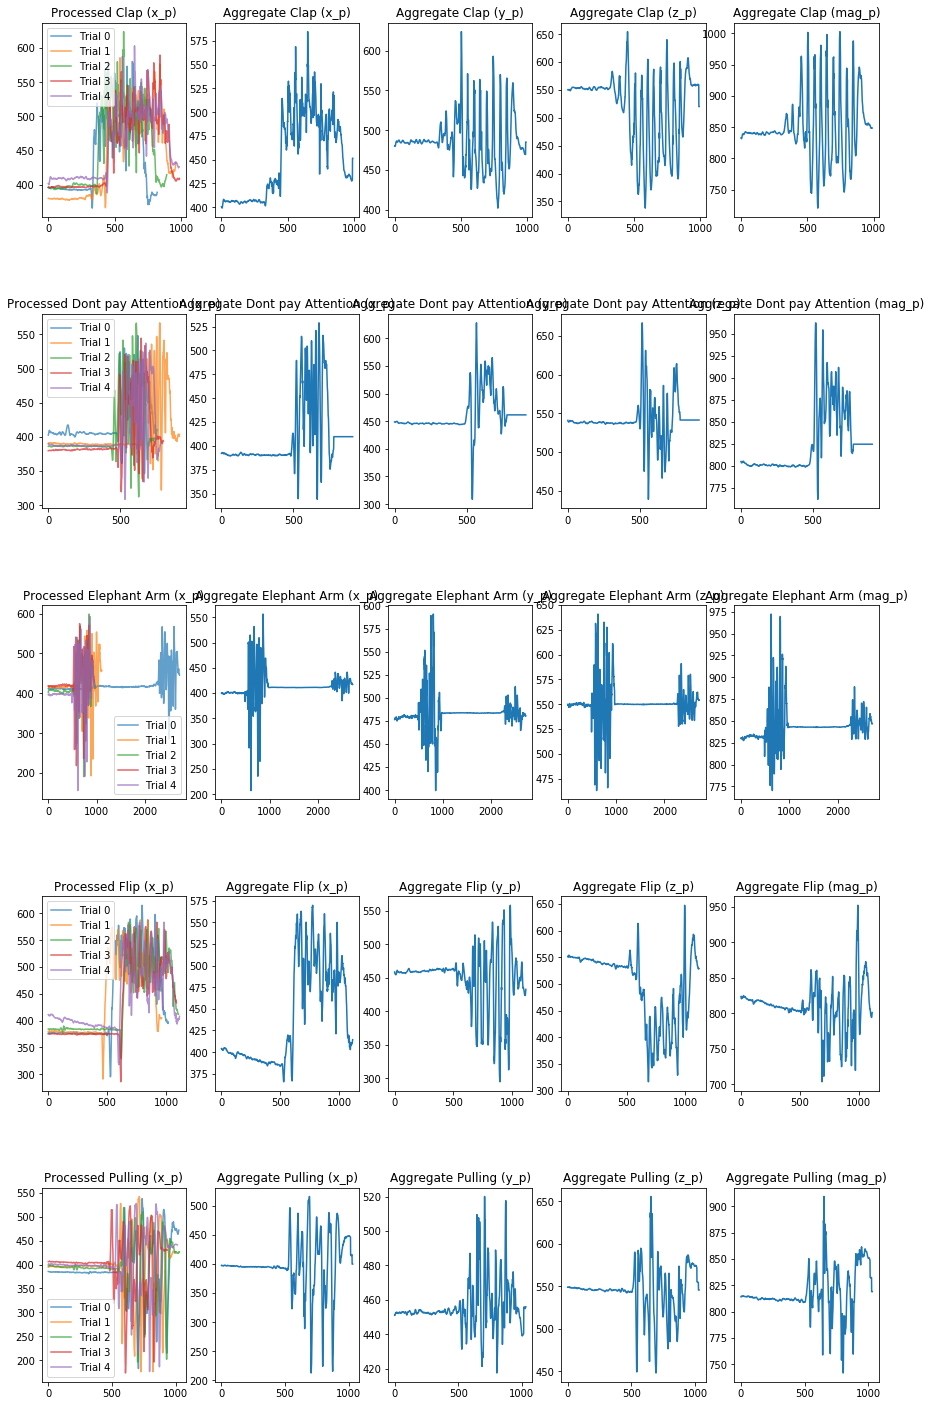

In [13]:
#Plotting mean processed values (Nicole)
# Let's plot the processed x signal, an aggregate signal, and the spectral analysis 
# of that signal. Because our sampling rate is ~77Hz (see trial.samplesPerSecond), the
# highest frequency we can detect is 77/2 (38.5Hz) due to the NyQuist frequency but this
# should be fine for human gesture motion
#
# I'm plotting the aggregate signal to see if there are *overall* trends in the data
# that we can take advantage of

selected_gesture_set = get_gesture_set_with_str("Nicole")
map_gestures_to_trials = selected_gesture_set.map_gestures_to_trials
fig, axes = plt.subplots(len(map_gestures_to_trials), 5, figsize=(15, 5 * len(map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(map_gestures_to_trials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = map_gestures_to_trials[gestureName]
    trialNum = 0
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x_p, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title("Processed " + gestureName + " (x_p)")
    axes[index][0].legend()
    
    aggregate_x_p = selected_gesture_set.create_aggregate_signal(gestureName, "x_p")
    axes[index][1].plot(aggregate_x_p, label="Aggregate")
    axes[index][1].set_title("Aggregate " + gestureName + " (x_p)")
    
    aggregate_y_p = selected_gesture_set.create_aggregate_signal(gestureName, "y_p")
    axes[index][2].plot(aggregate_y_p, label="Aggregate")
    axes[index][2].set_title("Aggregate " + gestureName + " (y_p)")
    
    aggregate_z_p = selected_gesture_set.create_aggregate_signal(gestureName, "z_p")
    axes[index][3].plot(aggregate_z_p, label="Aggregate")
    axes[index][3].set_title("Aggregate " + gestureName + " (z_p)")
    
    aggregate_mag_p = selected_gesture_set.create_aggregate_signal(gestureName, "mag_p")
    axes[index][4].plot(aggregate_mag_p, label="Aggregate")
    axes[index][4].set_title("Aggregate " + gestureName + " (mag_p)")

    index = index + 1

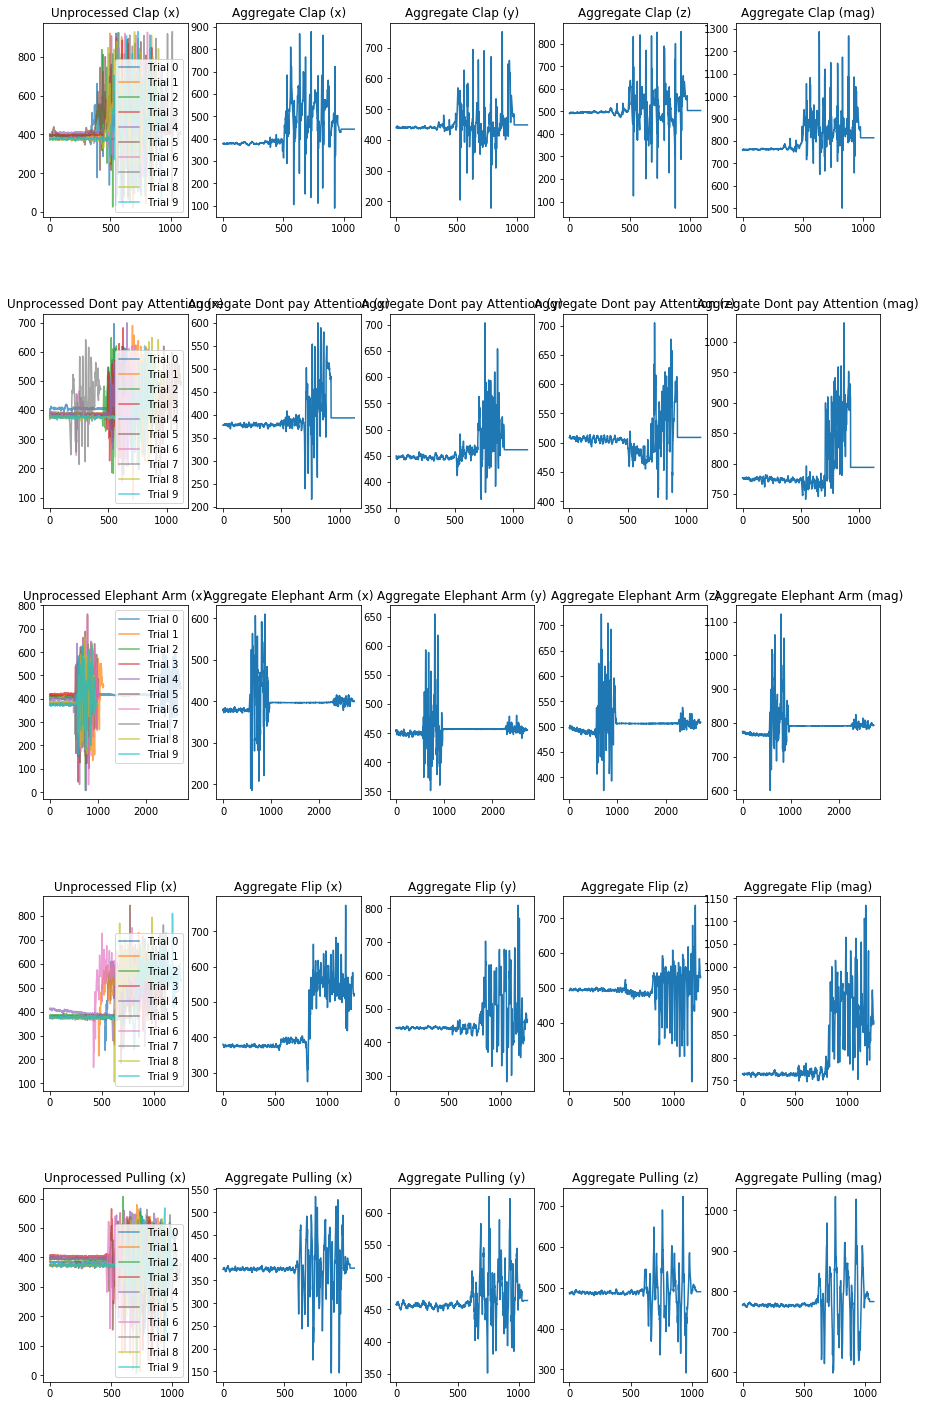

In [14]:
#Plotting mean raw values (Combined)
# Let's plot the processed x signal, an aggregate signal, and the spectral analysis 
# of that signal. Because our sampling rate is ~77Hz (see trial.samplesPerSecond), the
# highest frequency we can detect is 77/2 (38.5Hz) due to the NyQuist frequency but this
# should be fine for human gesture motion
#
# I'm plotting the aggregate signal to see if there are *overall* trends in the data
# that we can take advantage of

selected_gesture_set = get_gesture_set_with_str("Combined")
map_gestures_to_trials = selected_gesture_set.map_gestures_to_trials
fig, axes = plt.subplots(len(map_gestures_to_trials), 5, figsize=(15, 5 * len(map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(map_gestures_to_trials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = map_gestures_to_trials[gestureName]
    trialNum = 0
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title("Unprocessed " + gestureName + " (x)")
    axes[index][0].legend()
    
    aggregate_x = selected_gesture_set.create_aggregate_signal(gestureName, "x")
    axes[index][1].plot(aggregate_x, label="Aggregate")
    axes[index][1].set_title("Aggregate " + gestureName + " (x)")
    
    aggregate_y = selected_gesture_set.create_aggregate_signal(gestureName, "y")
    axes[index][2].plot(aggregate_y, label="Aggregate")
    axes[index][2].set_title("Aggregate " + gestureName + " (y)")
    
    aggregate_z = selected_gesture_set.create_aggregate_signal(gestureName, "z")
    axes[index][3].plot(aggregate_z, label="Aggregate")
    axes[index][3].set_title("Aggregate " + gestureName + " (z)")
    
    aggregate_mag = selected_gesture_set.create_aggregate_signal(gestureName, "mag")
    axes[index][4].plot(aggregate_mag, label="Aggregate")
    axes[index][4].set_title("Aggregate " + gestureName + " (mag)")

    index = index + 1

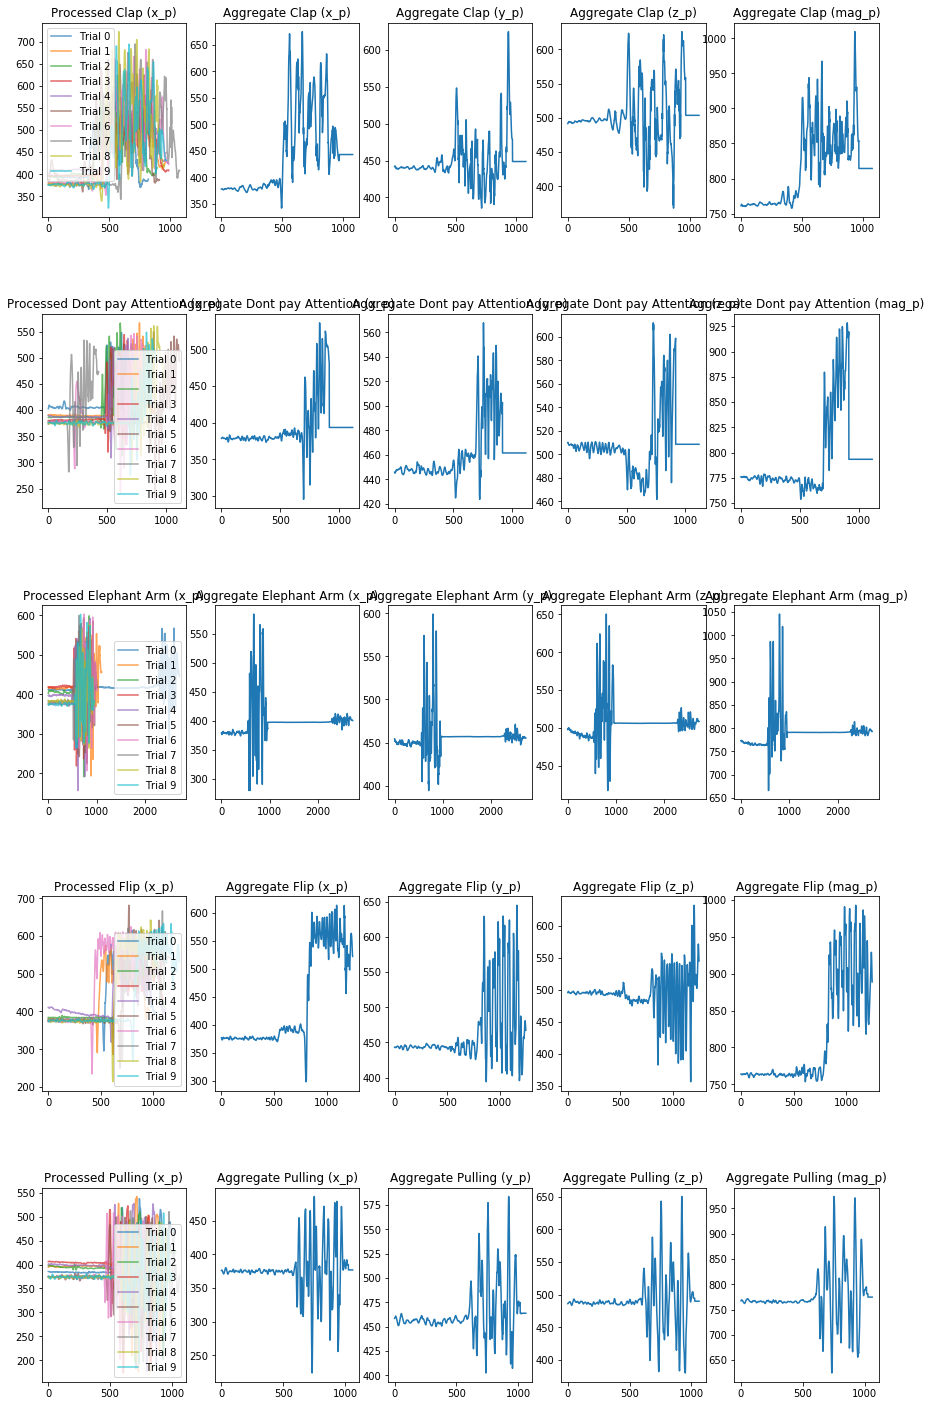

In [15]:
#Plotting mean processed values (Combined)
# Let's plot the processed x signal, an aggregate signal, and the spectral analysis 
# of that signal. Because our sampling rate is ~77Hz (see trial.samplesPerSecond), the
# highest frequency we can detect is 77/2 (38.5Hz) due to the NyQuist frequency but this
# should be fine for human gesture motion
#
# I'm plotting the aggregate signal to see if there are *overall* trends in the data
# that we can take advantage of

selected_gesture_set = get_gesture_set_with_str("Combined")
map_gestures_to_trials = selected_gesture_set.map_gestures_to_trials
fig, axes = plt.subplots(len(map_gestures_to_trials), 5, figsize=(15, 5 * len(map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(map_gestures_to_trials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = map_gestures_to_trials[gestureName]
    trialNum = 0
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x_p, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title("Processed " + gestureName + " (x_p)")
    axes[index][0].legend()
    
    aggregate_x_p = selected_gesture_set.create_aggregate_signal(gestureName, "x_p")
    axes[index][1].plot(aggregate_x_p, label="Aggregate")
    axes[index][1].set_title("Aggregate " + gestureName + " (x_p)")
    
    aggregate_y_p = selected_gesture_set.create_aggregate_signal(gestureName, "y_p")
    axes[index][2].plot(aggregate_y_p, label="Aggregate")
    axes[index][2].set_title("Aggregate " + gestureName + " (y_p)")
    
    aggregate_z_p = selected_gesture_set.create_aggregate_signal(gestureName, "z_p")
    axes[index][3].plot(aggregate_z_p, label="Aggregate")
    axes[index][3].set_title("Aggregate " + gestureName + " (z_p)")
    
    aggregate_mag_p = selected_gesture_set.create_aggregate_signal(gestureName, "mag_p")
    axes[index][4].plot(aggregate_mag_p, label="Aggregate")
    axes[index][4].set_title("Aggregate " + gestureName + " (mag_p)")

    index = index + 1